<a href="https://colab.research.google.com/github/ArthurFDLR/pose-classification-kit/blob/master/BodyPoseClassification-Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤙 Pose Classification kit body model design

This Notebook can be used to create Neural Network classifiers running in the [Pose Classification Kit](https://github.com/ArthurFDLR/pose-classification-kit).

First, we have to import several libraries to visualize our dataset and create a new model.

In [1]:
# Visualization tools 
from IPython.display import display, HTML, Markdown

from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Computation tools 
from pathlib import Path
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows', 5)

%tensorflow_version 2.x
import tensorflow
from tensorflow import keras

print('Available GPU:')
!nvidia-smi -L
print('\nTensorFlow use GPU at: {}'.format(tensorflow.test.gpu_device_name()))

Available GPU:
GPU 0: Tesla T4 (UUID: GPU-a11feed7-c321-6344-4776-2ee7dde337e0)

TensorFlow use GPU at: /device:GPU:0


## Dataset exploration

While OpenHand already contains a basic dataset, you can easily create and import your own using the application!

In [2]:
dataset_df = pd.read_csv("https://raw.githubusercontent.com/ArthurFDLR/pose-classification-kit/master/pose_classification_kit/datasets/BodyPose_Dataset.csv")
labels = dataset_df.label.unique()

display(Markdown("## Complete dataset view"))
display(dataset_df)

df_body_labels = dataset_df.groupby('label')

display(Markdown("## Number of samples per label and hand"))
display(
    pd.DataFrame(
        [df_body_labels.size()],
        columns=labels,
        index=["Nbr of entries"],
        )
)

## Complete dataset view

,label,accuracy,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14,x15,y15,x16,y16,x17,y17,x18,y18,x19,y19,x20,y20,x21,y21,x22,y22,x23,y23,x24,y24
0,Seated,19.508690,-0.060776,0.497554,-0.085367,0.360305,-0.206404,0.359822,-0.254659,0.157586,-0.068586,0.093048,0.003926,0.367953,0.052554,0.198201,0.052288,0.101291,-0.069057,0.084698,-0.141862,0.068745,-0.003900,-0.117274,0.125038,-0.424617,0.003923,0.092650,0.190280,-0.093207,0.157517,-0.424847,-0.076973,0.537926,-0.020513,0.537848,-0.133506,0.529790,-0.004316,0.521619,0.246689,-0.537926,0.254659,-0.505494,0.125220,-0.481106,0.238224,-0.529721,0.181949,-0.529865,0.117234,-0.472980
1,Seated,19.548573,-0.064262,0.501585,-0.088978,0.364251,-0.210033,0.363897,-0.250737,0.161617,-0.072216,0.097050,0.000255,0.364359,0.048789,0.202146,0.048557,0.105223,-0.072845,0.088723,-0.145644,0.072785,-0.007609,-0.113116,0.113625,-0.420526,0.000118,0.096654,0.186695,-0.089216,0.153778,-0.428637,-0.080508,0.541949,-0.023966,0.541849,-0.136952,0.533824,-0.007863,0.517799,0.242809,-0.541949,0.250737,-0.517829,0.121459,-0.477317,0.218503,-0.525648,0.170166,-0.525665,0.113249,-0.468936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4775,Warrior2_right,19.477709,-0.112819,0.379597,-0.012480,0.266645,-0.131722,0.272748,-0.326262,0.272838,-0.476629,0.272996,0.100155,0.266382,0.257147,0.228754,0.445348,0.229094,0.043686,-0.053334,-0.043725,-0.053285,-0.238322,-0.116005,-0.225740,-0.335506,0.106643,-0.047116,0.294830,-0.203900,0.457601,-0.329363,-0.113076,0.404608,-0.094174,0.404547,0.000000,0.000000,-0.012639,0.379828,0.451243,-0.404608,0.476592,-0.385756,0.476629,-0.329575,-0.338578,-0.385679,-0.326176,-0.373277,-0.194672,-0.372831
4776,Warrior2_right,19.388601,-0.104081,0.384374,-0.003160,0.271034,-0.122844,0.277137,-0.330709,0.277009,-0.482145,0.277112,0.103990,0.270820,0.267796,0.232960,0.456595,0.233340,0.047115,-0.050467,-0.040740,-0.050435,-0.236115,-0.113466,-0.223615,-0.334045,0.110384,-0.044206,0.305363,-0.207901,0.463014,-0.327914,-0.110193,0.409607,-0.091275,0.403390,0.000000,0.000000,-0.003413,0.384700,0.456612,-0.409607,0.482145,-0.384608,0.482145,-0.334005,-0.337035,-0.384421,-0.324586,-0.371971,-0.192422,-0.371559


## Number of samples per label and hand

,Seated,Stand_RightArmRaised,standing,T,Tree_left,Tree_right,UpwardSalute,Warrior2_left,Warrior2_right
Nbr of entries,606,503,521,503,580,502,526,521,515


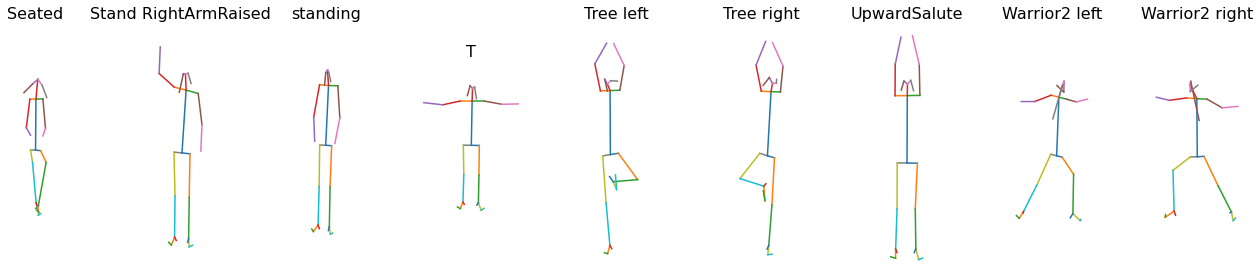

In [3]:
label_display = labels
posePartPairs = [1, 8, 1, 2, 1, 5, 2, 3, 3, 4, 5, 6, 6, 7, 8, 9, 9, 10, 10, 11, 8, 12, 12, 13, 13, 14, 1, 0, 0, 15, 15, 17, 0, 16, 16, 18, 14, 19, 19, 20, 14, 21, 11, 22, 22, 23, 11, 24]

fig, axs = plt.subplots(1, len(label_display), figsize=(len(labels)*2,4))

for ax, label in zip(axs, label_display):
    sample_data = dataset_df[(dataset_df.label==label)].drop(['label', 'accuracy'], axis=1).to_numpy().mean(axis=0)
    sample_data_2D = np.stack([sample_data[::2], sample_data[1::2]]).T
    for keypoint_1, keypoint_2 in np.stack([posePartPairs[::2], posePartPairs[1::2]]).T:
        ax.plot(sample_data_2D[(keypoint_1, keypoint_2),0],
                sample_data_2D[(keypoint_1, keypoint_2),1])
        ax.set_aspect("equal")
        ax.axis('off')
        ax.set_ylim([-.7,.7])
        ax.set_title(label.replace('_', ' '), fontsize=16)

fig.tight_layout()
fig.show()

Now that we know what the dataset looks like, we can create NumPy arrays to train TensorFlow models. We are only using samples associated with the right hand. However, you can easily use the whole dataset to train a single neural network through hands vertical symmetry.

In [4]:
test_split = 0.15

# Find the minimum number of samples accross categories to uniformly distributed sample sets
total_size_cat = df_body_labels.size().min()
test_size_cat  = int(total_size_cat*test_split)
train_size_cat = total_size_cat - test_size_cat

x_train = []
x_test  = []
y_train = []
y_test  = []

# Iterate over each labeled group
for label, group in df_body_labels:
    # remove irrelevant columns
    group_array = group.drop(['label', 'accuracy'], axis=1).to_numpy()
    np.random.shuffle(group_array)
    
    x_train.append(group_array[:train_size_cat])
    y_train.append([label]*train_size_cat)
    x_test.append(group_array[train_size_cat : train_size_cat+test_size_cat])
    y_test.append([label]*test_size_cat)

# Concatenate sample sets as numpy arrays and shuffle in unison
shuffler_test = np.random.permutation(test_size_cat*len(labels))
shuffler_train = np.random.permutation(train_size_cat*len(labels))
x_train = np.concatenate(x_train, axis=0)[shuffler_train]
x_test = np.concatenate(x_test, axis=0)[shuffler_test]
y_train = np.concatenate(y_train, axis=0)[shuffler_train]
y_test = np.concatenate(y_test, axis=0)[shuffler_test]

# One-hot encoding
y_train_onehot = keras.utils.to_categorical([list(labels).index(sample) for sample in y_train])
y_test_onehot  = keras.utils.to_categorical([list(labels).index(sample) for sample in y_test])

# Change keypoints format
BODY25_to_BODY18 = [0, 1, 16, 17, 15, 16, 18, 19, 17, 18, 5, 6, 2, 3, 6, 7, 3, 4, 7, 8, 4, 5, 12, 13, 9, 10, 13, 14, 10, 11, 14, 15, 11, 12, 1, 2]
x_train = x_train[:, BODY25_to_BODY18]
x_test  = x_test[:, BODY25_to_BODY18]

display(HTML('''There are {n_cat} categories with a minimum of {min} samples.
                Given a training/test split ratio of {split}% on uniformly distributed sets,
                the training set has {n_train} samples and the test set has {n_test} samples:'''
             .format(n_cat=len(labels), min=total_size_cat, split=test_split*100, n_train=x_train.shape[0], n_test=x_test.shape[0])))
display(pd.DataFrame([str(d.shape) for d in (x_train, x_test, y_train, y_test, y_train_onehot, y_test_onehot)],
                     index = ['x_train', 'x_test', 'y_train', 'y_test', 'y_train_onehot', 'y_test_onehot'],
                     columns = ['shape']))

,shape
x_train,"(3843, 36)"
x_test,"(675, 36)"
y_train,"(3843,)"
y_test,"(675,)"
y_train_onehot,"(3843, 9)"
y_test_onehot,"(675, 9)"


## Models exploration

This section is optional. The following blocks can be used to compare different model architecture and training processes.

In [8]:
model_train_history = {}
input_dim = x_train.shape[1]
validation_split = 0.20
epochs = 15

In [9]:
model = keras.models.Sequential(name = 'ANN-3x64-Dropouts',
                                   layers =
    [
        keras.layers.InputLayer(input_shape=input_dim),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(len(labels), activation=keras.activations.softmax),
    ]
)

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_train_history[model] = model.fit(
    x=x_train,
    y=y_train_onehot,
    epochs=epochs,
    batch_size=4,
    validation_split=validation_split,
    shuffle=True,
    verbose=1,
)

Model: "ANN-3x64-Dropouts"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                2368      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 9)           

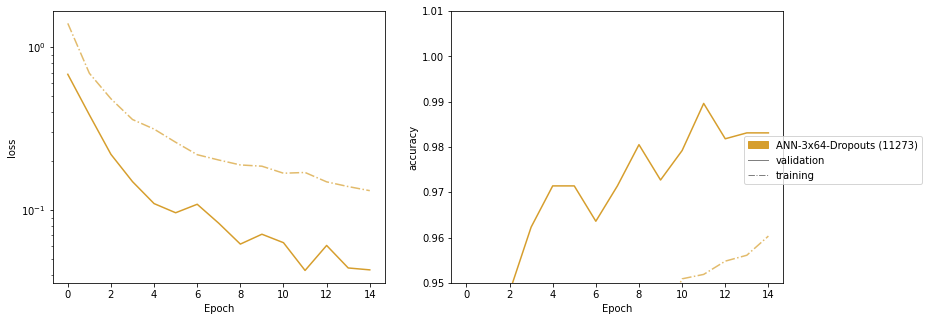

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))
colors_graph = ["#d69e2d",
                "#927ced",
                "#73bd4d",
                "#e462c0",
                "#eb5e52"]
handles = []

for (model, history), color in zip(model_train_history.items(), colors_graph):
    label = '{} ({})'.format(model.name, model.count_params())
    axs[0].plot(history.history['loss'], c=color, ls='-.', alpha=.7)
    axs[1].plot(history.history['accuracy'], c=color, ls='-.', alpha=.7)
    axs[0].plot(history.history['val_loss'], c=color)
    axs[1].plot(history.history['val_accuracy'], c=color)
    handles.append(mpatches.Patch(color=color, label=label))

for ax in axs:
    ax.set_xlabel('Epoch')
axs[0].set_ylabel('loss')
axs[0].set_yscale('log')
axs[1].set_ylabel('accuracy')
axs[1].set_ylim(0.95,1.01)

handles.append(Line2D([0], [0], color='grey', lw=1, ls='-', label='validation'))
handles.append(Line2D([0], [0], color='grey', lw=1, ls='-.', label='training'))

fig.subplots_adjust(right=0.85)
fig.legend(handles=handles,
           loc="center right",
           borderaxespad=1)

## Model export

Once you have a good model, you can save it on your Google Drive. The model is saved using the [folder hierarchy of the Pose Classifier Kit](https://github.com/ArthurFDLR/pose-classification-kit#pose-classifier-models).

In [11]:
from google.colab import drive
from pathlib import Path

content_path = Path('/').absolute() / 'content'
drive_path = content_path / 'drive'
drive.mount(str(drive_path))

Mounted at /content/drive


In [12]:
model = keras.models.Sequential(name = '9Classes_3x64',
                                   layers =
    [
        keras.layers.InputLayer(input_shape=input_dim),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(len(labels), activation=keras.activations.softmax),
    ]
)

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

save_path = drive_path / 'My Drive'
for subfolder in ['Pose Classification Kit', 'Models', model.name]:
    save_path /= subfolder
    if not (save_path).is_dir():
        %mkdir "{save_path}"


model_path = save_path / '{name}_body.h5'.format(name = model.name)

model.fit(
    x=x_train,
    y=y_train_onehot,
    epochs=15,
    batch_size=4,
    validation_split=0.15,
    shuffle=True,
    callbacks=[keras.callbacks.ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True)],
    verbose = 2,
)

class_file = open(save_path / 'class.txt', 'w')
for i, label_i in enumerate(labels):
    class_file.write((',' if i!=0 else '') + label_i)
class_file.close()

Model: "9Classes_3x64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                2368      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 9)                 585       
Total params: 11,273
Trainable params: 11,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
817/817 - 2s - loss: 0.7689 - accuracy: 0.7373 - val_loss: 0.1954 - val_accuracy: 0.9532

Epoch 00001: val_loss improved from inf to 0.19536, saving model to /content/drive/My Drive/Pose Classification Kit/Models/9Classes_3x64/9Classes_

In [16]:
model_test = keras.models.load_model(model_path)
model_test.evaluate(x=x_test, y=y_test_onehot)

22/22 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 0.9941


[0.02988944761455059, 0.9940740466117859]